In [4]:
import numpy as np
import line_profiler

def sliding_window(sequence, win_size, step=1):
    # Verify the inputs
    try:
        it = iter(sequence)
    except TypeError:
        raise Exception("**ERROR** sequence must be iterable.")
    if not ((type(win_size) == type(0)) and (type(step) == type(0))):
        raise Exception("**ERROR** type(winSize) and type(step) must be int.")
    if step > win_size:
        raise Exception("**ERROR** step must not be larger than winSize.")
    if win_size > len(sequence):
        raise Exception("**ERROR** winSize must not be larger than sequence length.")

    # Pre-compute number of chunks to emit
    num_chunks = ((len(sequence) - win_size) / step) + 1

    # Do the work
    for i in range(0, int(num_chunks * step), step):
        yield sequence[i:i + win_size]
        
def calculate_distances(timeseries, subsequence, distance_measure):
    if distance_measure == "mass_v1" :
        return mass_v1(subsequence, timeseries)
    elif distance_measure == "mass_v2" :
        return mass_v2(timeseries, subsequence)
    elif distance_measure == "brute":
        return euclidean_distance_unequal_lengths(timeseries, subsequence)

def euclidean_distance(t1, t2):
    return np.sqrt(sum((t1 - t2) ** 2))

def euclidean_distance_unequal_lengths(t, s):##O(m)
    ## return a array of distance between 'shapelet' and every slices of 'timeseries'
    distances = np.array([euclidean_distance(np.array(s1), s) for s1 in sliding_window(t, len(s))])
    return distances

def dot_products_1(q, t):
    m, n = len(q), len(t)
    t_a = np.concatenate([t, np.zeros(n)])
    # reverse the Query
    q_r = q[::-1]
    q_ra = np.concatenate([q_r, np.zeros(2 * n - m)])
    q_raf = np.fft.fft(q_ra)
    t_af = np.fft.fft(t_a)
    qt = np.fft.ifft(q_raf * t_af)
    return qt

def dot_products_2(q, t):
    # concatenante n-m zeros for Query
    m, n = len(q), len(t)
    # reverse the Query
    q_r = q[::-1]
    q_ra = np.concatenate([q_r, np.zeros(n - m)])
    q_raf = np.fft.fft(q_ra)
    t_af = np.fft.fft(t)
    qt = np.fft.ifft(q_raf * t_af)
    return qt

def mass_v1(q, t):
    m, n = len(q), len(t)
    # Z-normalization of Query
    q = (q-np.mean(q)) / np.std(q)
    qt = dot_products_1(q, t)
    #compute the mean and standard deviation of Time Series
    sum_q = np.sum(q)
    sum_q2 = np.sum(np.power(q,2))

    #cache a cumulative sum of values
    cum_sum_t = np.cumsum(t)
    cum_sum_t2 = np.cumsum(np.power(t,2))

    #sum of x and x square for [0, n-m] subsequences of length m
    #sumt2 = cum_sum_t2[m-1:] - cum_sum_t2[:- m+1]
    #sumt = cum_sum_t[m-1:] - cum_sum_t[:- m+1]
    sumt2 = cum_sum_t2[m:] - cum_sum_t2[: n-m]
    sumt = cum_sum_t[m:] - cum_sum_t[: n- m]
    meant = sumt / m
    #standard deviation of every subsequence of length m
    sigmat2 = (sumt2 / m) - (np.power(meant,2))
    sigmat = np.sqrt(sigmat2)

    dist = (sumt2 - 2 * sumt * meant + m * (np.power(meant,2))) / sigmat2 - 2 * (qt[m:n] - sum_q * meant) / sigmat + sum_q2
    dist = np.sqrt(dist)
    #distance here is a complex number, need to return its amplitude/absolute value
    #return a vector with size of n-m+1
    return np.abs(dist)

#@profile
def mass_v2(x, y):
    #x is the data, y is the query
    n, m = len(x), len(y)

    #%compute y stats -- O(n)
    meany = np.mean(y)

    sigmay = np.std(y)
    #compute x stats -- O(n)
    #compute the average of the first m elements in 'x'
    def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, np.zeros(N)))
        cum_v = cumsum[N:] - cumsum[:-N]
        cum_v1 = np.divide(cum_v[:N],range(1,N+1))
        cum_v2 = cum_v[N:]/ float(N)
        return np.concatenate([cum_v1,cum_v2])

    def running_std(x, N):
        x2 = np.power(x, 2)
        cumsum2 = np.cumsum(np.insert(x2, 0, np.zeros(N)))
        cum_v = cumsum2[N:] - cumsum2[:-N]
        cum_v1 = np.divide(cum_v[:N],range(1,N+1))
        cum_v2 = cum_v[N:]/ float(N)
        cumstd2 = np.concatenate([cum_v1,cum_v2])
        return (cumstd2 - running_mean(x, N) ** 2) ** 0.5

    #compute the moving average and standard deviation of Time Series
    meanx = running_mean(x, m)
    sigmax = running_std(x, m)

    #The main trick of getting dot products in O(n log n) time
    z = dot_products_2(y, x)
    dist = 2 * (m - (z[m-1:n] - m * meanx[m-1:n] * meany) / (sigmax[m-1:n] * sigmay))
    dist = np.sqrt(dist)
    #distance here is a complex number, need to return its amplitude/absolute value
    #return a vector with size of n-m+1
    return np.abs(dist)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, np.zeros(N)))
    cum_v = cumsum[N:] - cumsum[:-N]
    cum_v1 = np.divide(cum_v[:N],range(1,N+1))
    cum_v2 = cum_v[N:]/ float(N)
    return np.concatenate([cum_v1,cum_v2])

def running_std(x, N):
    x2 = np.power(x, 2)
    cumsum2 = np.cumsum(np.insert(x2, 0, np.zeros(N)))
    cum_v = cumsum2[N:] - cumsum2[:-N]
    cum_v1 = np.divide(cum_v[:N],range(1,N+1))
    cum_v2 = cum_v[N:]/ float(N)
    cumstd2 = np.concatenate([cum_v1,cum_v2])
    return (cumstd2 - running_mean(x, N) ** 2) ** 0.5

#@profile
def mass_v3(x, y, meanx, meany, sigmax, sigmay, sigmaQplus):
    #x is the data, y is the query
    n, m = len(x), len(y)

    #The main trick of getting dot products in O(n log n) time
    z = dot_products_2(y, x)
    #dist = 2 * m * (1 - (z[m-1:n]/m - meanx[m-1:n] * meany) / (sigmax[m-1:n] * sigmay))
    #dist = np.sqrt(dist)
    #distance here is a complex number, need to return its amplitude/absolute value
    #return a vector with size of n-m+1

    sigmaxy = sigmax * sigmay
    q_ij = (z[m-1:n] / m - meanx * meany) / sigmaxy
    dist = np.sqrt(2 * m * (1 - q_ij))

    # Q is a subsequence, T is the entire timeseries, meanT/sigmaT are lists of elements
    coeff = sigmay / sigmaQplus
    # compute the LB profile: q_ij
    # q_ij[q_ij <= 0] = (m ** 0.5) * coeff
    # q_ij[q_ij > 0] = ((m * (1 - q_ij ** 2)) ** 0.5) * coeff
    LB = np.abs(np.where(q_ij <= 0, (m ** 0.5) * coeff, np.where(q_ij > 0, ((m * (1 - q_ij ** 2)) ** 0.5) * coeff, q_ij)))
    qt = {idx: value for idx, value in enumerate(z[m-1:n])}

    lb_list = [(idx, dist) for idx, dist in enumerate(LB)]
    lb_list = sorted(lb_list, key=lambda d: d[1])
    return np.abs(dist), qt, lb_list #q_ij here is the LB profile

#@profile
def compute1Dist(meanQ, meanT, sigmaQ, sigmaT, QT, m):
    if sigmaT <= 0.0001:
        dist = 10000
    else:
        dist = 2 * (m - (QT - m * meanQ * meanT) / (sigmaQ * sigmaT))
    return abs(dist*0.5)

def linearComputeLB(LB, sigmaQ, sigmaQplus):
    #LB: [(rawIndex, value)]
    LB_new = [(rawIndex, value* sigmaQ / sigmaQplus) for (rawIndex,value) in LB]
    return LB_new

#@profile
def computeLB(QT, m, meanQ, meant, sigmaQ, sigmat, sigmaQplus):
    # Q is a subsequence, T is an entire timeseries
    qt = np.array([QT[i] for i in sorted(QT)])
    lenQT = len(qt)
    #print("length of QT is ", str(lenQT), "length of meant is ", str(len(meant)))
    # problem of LB, as when sigma<0.0001, skip
    #q_ij = (qt/m - meanQ*meant[:lenQT]) / sigmaQ * sigmat[:lenQT]
    q_ij = (qt / m - meanQ * meant) / sigmaQ * sigmat
    coeff= sigmaQ / sigmaQplus
    q_ij = np.abs(np.where(q_ij.real <= 0, (m ** 0.5) * coeff, np.where(q_ij.real > 0, ((m * (1 - q_ij.real ** 2)) ** 0.5) * coeff, q_ij)))
    lb_list = [(idx, dist) for idx, dist in enumerate(q_ij)]
    lb_list = sorted(lb_list, key=lambda d: d[1])
    return lb_list

#@profile
def computeMeanSigma(dataset, m):
    mean = {}
    sigma = {}
    for ts in dataset.values():
        TS = ts.timeseries
        n = len(TS)
        # compute the moving average and standard deviation of Time Series
        mean_ts = running_mean(TS, n)
        sigma_ts = running_std(TS, n)
        mean[ts.name] = mean_ts[m - 1:n]
        sigma[ts.name] = sigma_ts[m - 1:n]
    return mean, sigma

#@profile
# input: mean(m), sigma(m), mplus(m+1)
# output: mean_new(m+1), sigma_new(m+1)
def updateMeanSigma(dataset, mean, sigma, mplus):
    mean_new = {}
    sigma_new = {}
    for ts in dataset.values():
        TS = ts.timeseries
        n = len(TS)
        new_elem = TS[mplus-1:]
        mean_temp = mean[ts.name][:n-mplus+1]
        mean_new[ts.name] = (mean_temp * (mplus-1) + new_elem) / mplus

        sigma_temp = sigma[ts.name][:n-mplus+1]
        ss_old = (mplus - 1) * (sigma_temp ** 2 + mean_temp ** 2)
        ss_new = ss_old + new_elem ** 2
        sigma_new[ts.name] = ((ss_new / mplus) - mean_new[ts.name] ** 2) ** 0.5

    return mean_new, sigma_new

false


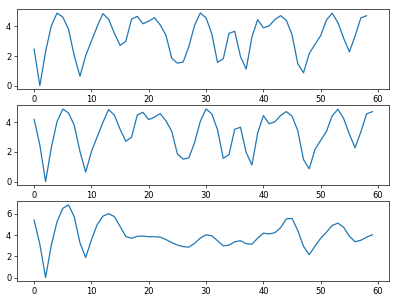

In [6]:
t = [-0.77065,-1.2791,-0.26209,1.5178,2.2806,1.0092,-0.51635,-1.5334,-0.77065,1.0092,2.5348,2.7891,1.772,-0.26209,-1.5334,-2.0419,-1.5334,-0.51635,-0.26209,-0.26209,-0.51635,-0.51635,-0.26209,-0.26209,-0.26209,-0.0078248,0.24645,0.24645,0.24645,0.24645,-0.0078248,-0.26209,-0.51635,-0.26209,-0.0078248,0.24645,0.24645,-0.0078248,-0.26209,-0.0078248,-0.0078248,-0.26209,-0.77065,-0.77065,-0.26209,-0.26209,-0.77065,0.50071,1.2635,2.2806,2.2806,1.2635,0.24645,-0.51635,-1.2791,-1.2791,-0.77065,-0.26209,-0.0078248,-0.0078248,-0.51635,-0.26209,-0.0078248,-0.0078248,0.50071]
#q = [1.5178,2.2806,1.0092,-0.51635,-1.5334,-0.77065,1.0092,2.5348,2.7891,1.772]
q = [-0.26209,1.5178,2.2806,1.0092,-0.51635,-1.5334]
dp_v1 = calculate_distances(t,q,"mass_v1")
#dp_v1 = 4.860921066932171,2.767395479432407,4.323144550074336e-08,2.845919417390394,4.965208898527445,6.068348331739017,6.225876340222012,5.618144992911787,4.378046161030111,3.189943743185972,2.700219913732508,3.20647934699347,4.439659937077373,5.149078211549052,4.994000199586344,4.34045712206409,3.020209165912931,2.919806997316525,3.361116993477324,3.812778146056428,4.354838182131623,5.334910437249482,5.902777114881272,6.047195684090057,5.550772582663577,4.274797168126932,2.418187686685143,0.948731495667246,3.173212722864377,5.020515437402084,5.832220821449746,5.586756512750778,5.049911991082823,5.05757926442138,5.269531089672382,5.060538566425972,4.334251379469987,3.450102547808075,3.16127922345593,3.150506702499492,2.971960268462285,3.084410436456894,4.037897155279941,5.358710776246317,6.106687895345971,6.077285847866007,5.58084592006326,4.665437291683676,3.697759847581922,2.884237819541795,2.439148583679835,3.492000787443618,4.896276354716258,5.161261835072533,4.580118176481192

dp_v2 = calculate_distances(t,q,"mass_v2")
dp_ed = calculate_distances(t,q,"brute")
if np.array_equal(dp_v1, dp_ed):
    print("true")
else:
    print("false")
    
from matplotlib import pyplot as plt
x_v1 = range(0, len(dp_v1))
x_v2 = range(0, len(dp_v2))
x_v3 = range(0, len(dp_ed))


figure = plt.figure(figsize=(8,6), dpi=60)
ax1 = figure.add_subplot(311)
ax2 = figure.add_subplot(312, sharex = ax1)
ax3 = figure.add_subplot(313, sharex = ax1)
ax1.plot(x_v1, dp_v1)
ax2.plot(x_v2, dp_v2)
ax3.plot(x_v3, dp_ed)
plt.show()

In [84]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [35]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
a= np.arange(20)
moving_average(a,n=3)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18.])

In [50]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, np.zeros(N)))
    cum_v = cumsum[N:] - cumsum[:-N]
    cum_v1 = np.divide(cum_v[:N],range(1,N+1))
    cum_v2 = cum_v[N:]/ float(N)
    return np.concatenate([cum_v1,cum_v2])
running_mean(a,3)

array([ 0. ,  0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. ,
       10. , 11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. ])

In [51]:
len(range(1,10))

9

In [54]:
def running_std1(x, N):
    x2 = np.power(x, 2)
    cumsum2 = np.cumsum(np.insert(x2, 0, np.zeros(N)))
    cum_v = cumsum2[N:] - cumsum2[:-N]
    cum_v1 = np.divide(cum_v[:N],range(1,N+1))
    cum_v2 = cum_v[N:]/ float(N)
    cumstd2 = np.concatenate([cum_v1,cum_v2])
    print(cumstd2)
    print(running_mean(x, N))
    return (cumstd2 - running_mean(x, N) ** 2) ** 0.5
A = [4, 8, 6, -1, -2, -3, -1, 3, 4, 5]

running_std1(A, 3)


[16.         40.         38.66666667 33.66666667 13.66666667  4.66666667
  4.66666667  6.33333333  8.66666667 16.66666667]
[ 4.          6.          6.          4.33333333  1.         -2.
 -2.         -0.33333333  2.          4.        ]


array([0.        , 2.        , 1.63299316, 3.8586123 , 3.55902608,
       0.81649658, 0.81649658, 2.49443826, 2.1602469 , 0.81649658])

array([], shape=(0, 5), dtype=float64)

In [69]:
np.std([4,8])

2.0